In [135]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fmin_bfgs

# Exercise 2.1: Logistic Regression (dimension-2, power-1, category-2, unregularised)
---

In exercise-1 and exercise-5 we look at _linear regression_, in the former fitting a straight line to 1D data and a plane to 2D data, both cases unregularised, and in the latter fitting a curved line to 1D data, observing both unregularised and regularised cases. On re-writing these notes, it was natural for me to progress from exercise-1 straight to exercise-5, and only then return to exercise-2, as here we change course in terms of technique and instead of considering _linear regression_ we now turn our hand to _logistic regression_.

In linear regression we want to fit some line or surface through a data set, such that it matches the data set as closely as possible, with the closeness usually measured in terms of the mean squared difference between the hypothesis values and the known data values. The resulting fit can then be used to interpolate or extrapolate the trend to other locations in the dimensionality of the problem, that are unknown in advance.

In logistic regression we only fit surfaces and not lines, even though it may seem that lines are being used as hypothesis functions at first glance, and we seek the parameters that make these surfaces into boundaries which separate different categories of data. Typically this is a binary category problem, and, even if we have more than two categories, we can still cast the problem as binary by creating multiple one-versus-all boundaries, one for each category. To simplify and standardise, the binary labels of 0 and 1 are typically used. To arrange things such that the boundary surface is adjusted as needed, we don't try and compare its plain value to the data in any way, but rather the sigmoid of its value. The sigmoid function varies between 0 and 1, with a steep rise between. By matching the sigmoid of the boundary surface to the data as best as possible, we thereby push the sigmoid = 0.5 location to be the desired boundary, which is tantamount to the 0 location of the boundary surface itself i.e. where the boundary object has value 0, then its sigmoid value is 0.5 and that is the boundary location we're after.

In this exercise set we look at two different 2D problems. The first problem requires a straight boundary to be found between two categories of data, which can be satisfied by using a plane as the boundary surface. The second problem requires a curved boundary surface, so meaning that we need higher power features in its description. The underlying concepts in both cases are still the same. Let's begin by having a look at the data of the first problem:

In [90]:
d1 = np.loadtxt('ex2/ex2data1.txt', delimiter=',')
d1.shape

(100, 3)

In [4]:
d1_X = d1[:,0:2]
d1_X.shape

(100, 2)

In [5]:
d1_y = np.transpose([d1[:,2]])
d1_y.shape

(100, 1)

In [220]:
del(d1)

In [6]:
d1_y_idx0 = np.where(d1_y == 0)[0]
d1_y_idx1 = np.where(d1_y == 1)[0]

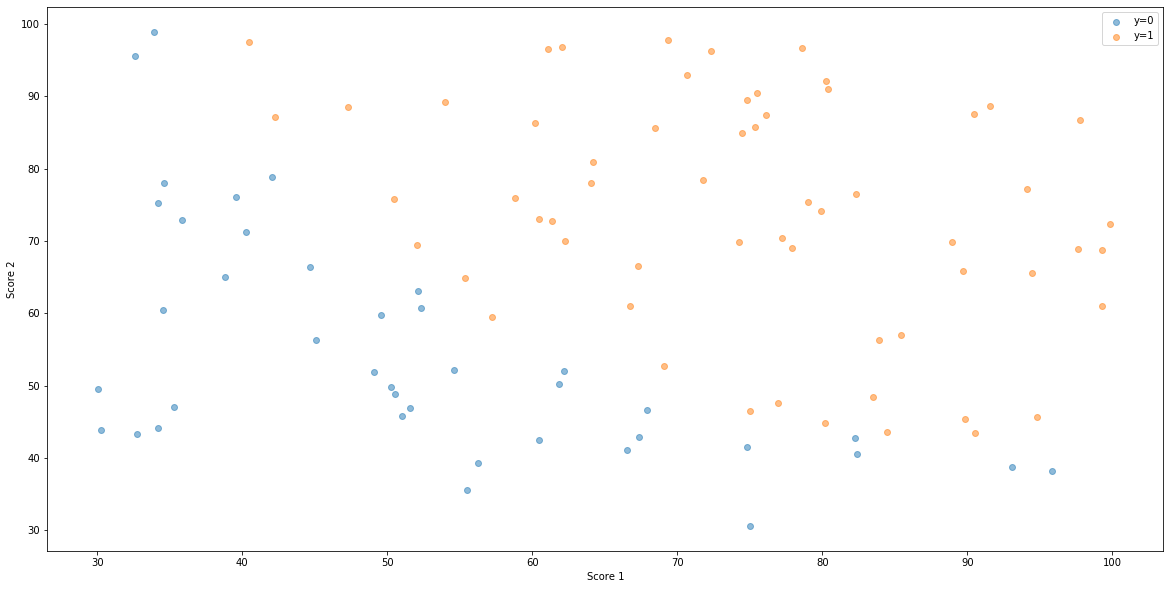

In [7]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d1_X[d1_y_idx0,0], d1_X[d1_y_idx0,1], color='C0', alpha=0.5)
ax.scatter(d1_X[d1_y_idx1,0], d1_X[d1_y_idx1,1], color='C1', alpha=0.5)
ax.set(xlabel='Score 1', ylabel='Score 2')
ax.legend(['y=0', 'y=1'])
plt.show()

---

Let's make a function to include an offset term via the dummy feature $x_0 = 1$:

In [8]:
def add_ones(X):
    return(np.append(np.ones([X.shape[0],1]), X, axis=1))

In [9]:
d1_X_ones = add_ones(d1_X)
d1_X_ones.shape

(100, 3)

Note that in this exercise set we don't normalise the data features. Not sure why Andrew left it out, but that's how it is.

---

Now define the sigmoid function and test:

In [10]:
def sigmoid(g):
    return(1 / (1 + np.exp(-g)))

In [73]:
g_test = np.linspace(-10, 10, 100)
h_test = sigmoid(g_test)
l_test = np.log(h_test)

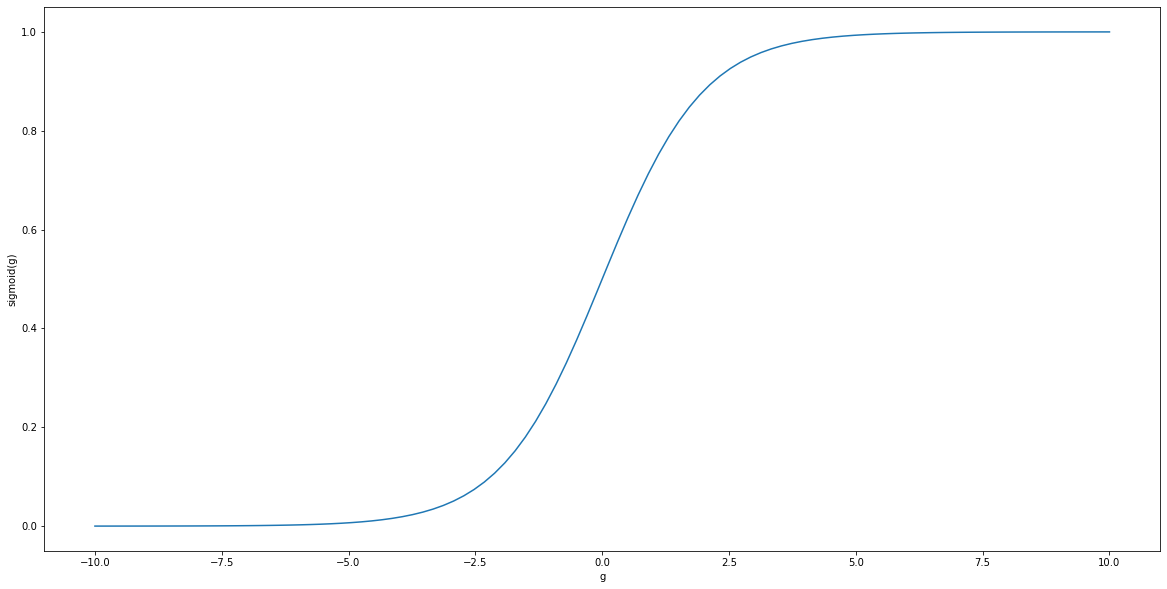

In [74]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(g_test, h_test, '-', color='C0')
ax.set(xlabel='g', ylabel='sigmoid(g)')
plt.show()

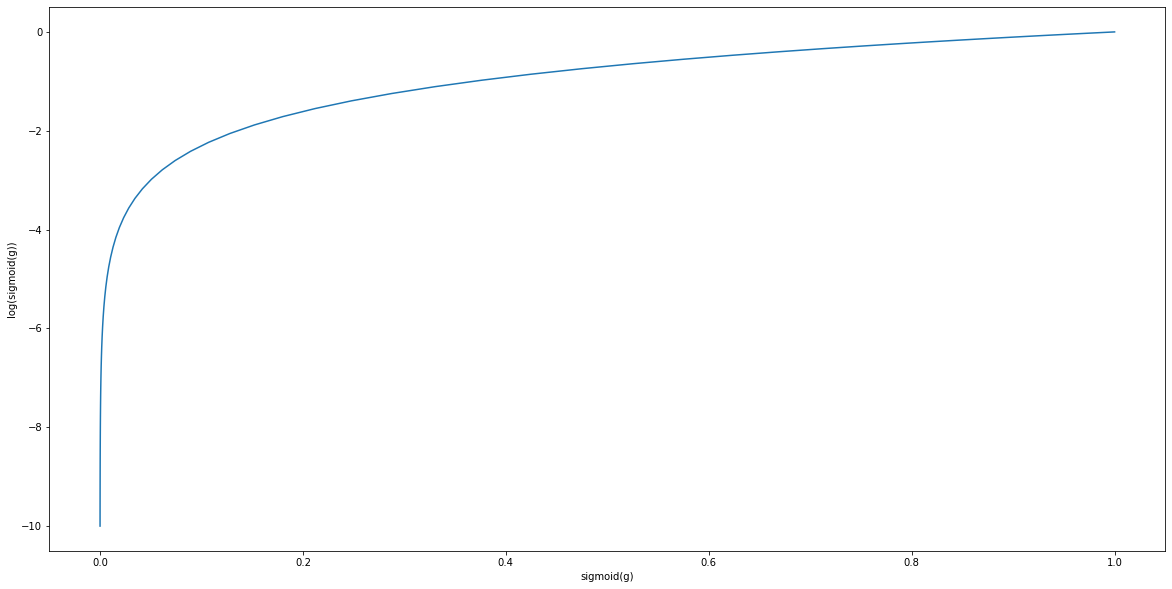

In [75]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(h_test, l_test, '-', color='C0')
ax.set(xlabel='sigmoid(g)', ylabel='log(sigmoid(g))')
plt.show()

In [76]:
sigmoid(0)

0.5

---

Now define the cost function, which includes regularisation terms for later use. Note that rather than being called by our own hand crafted gradient descent function, this will be called by the optimisation function ``fmin_bfgs`` (I'm unsure of the differences between this and ``fmin_cg`` used in ex5), which can calculate the required derivatives internally, hence the derivative toggle switch in the following. Also note that this optimisation function works exclusively with row vectors for the $\overrightarrow{\theta}$ parameters, hence the check and conversion to a column vector at the start of the function, for internal consistency.

Observe that this is not a least-mean-squares cost function. Even though we want the sigmoid of the boundary surface to match the data closely, and so a least-mean-squares approach is not unfeasible, a log cost function is used instead. This is applicable for the binary category labels we have in logistic regression problems, as it strongly penalises any predicted value that is not close to either 0 or 1. However, it can be seen that the regularisation terms in both the cost and its derivative are the same as those in the least-mean-squares cost function:

In [184]:
def get_cost(
    theta,
    lamb,
    X,
    y,
    get_derivative=True,
):

    if (theta.ndim == 1):
        theta = np.transpose([theta])

    m = X.shape[0]
    g = np.dot(X, theta)
    h = sigmoid(g) # These are the predictions for the y values we're trying to match i.e. h is an array of the same size as y
    h_minus_y = h - y

    cost = \
          (-1 / m) \
        * np.sum((y * np.log(h)) + ((1-y) * np.log(1-h))) \
        + (lamb / (2 * m)) * np.sum(np.power(theta[1:], 2))

    if (not get_derivative):
        return(cost)
    else:
        dcost_by_dtheta = (1 / m) * np.dot(np.transpose(X), h_minus_y)
        dcost_by_dtheta[1:] += (lamb / m) * theta[1:]
        return(cost, dcost_by_dtheta)

In [185]:
def get_theta(
    theta_init,
    lamb,
    iters_num,
    X,
    y,
    disp=True,
):

    theta = fmin_bfgs(
        get_cost,
        theta_init,
        args=(
            lamb,
            X,
            y,
            False,
        ),
        maxiter=iters_num,
        disp=disp,
    )

    theta = np.transpose([theta])

    return(theta)

In [186]:
d1_cost, d1_dcost_by_dtheta = get_cost(
    np.array([[0.0],[0.0],[0.0]]),
    0,
    d1_X_ones,
    d1_y,
)
print(d1_cost)
print(d1_dcost_by_dtheta)
# 0.6931471805599453
# [[ -0.1       ]
#  [-12.00921659]
#  [-11.26284221]]

0.6931471805599453
[[ -0.1       ]
 [-12.00921659]
 [-11.26284221]]


In [187]:
d1_cost, d1_dcost_by_dtheta = get_cost(
    np.array([[-24.0],[0.2],[0.2]]),
    0,
    d1_X_ones,
    d1_y,
)
print(d1_cost)
print(d1_dcost_by_dtheta)
# 0.21833019382659774
# [[0.04290299]
#  [2.56623412]
#  [2.64679737]]

0.21833019382659774
[[0.04290299]
 [2.56623412]
 [2.64679737]]


---

Even though it's not a requirement of the exercise as stated, out of interest let's try the gradient descent method from exercise-1:

In [190]:
def gradient_descent(
    theta,
    lamb,
    alpha,
    iters_num,
    X,
    y,
):

    cost, dcost_by_dtheta = get_cost(theta, lamb, X, y) # Get the initial cost and derivatives for the initial parameters, outside of the number of iterations to be done. The final cost in the list will then be for the final parameters found.
    costs = [cost]

    for iters_idx in range(iters_num):
        theta -= alpha * dcost_by_dtheta
        cost, dcost_by_dtheta = get_cost(theta, lamb, X, y)
        costs.append(cost)

    return(theta, costs)

In [191]:
d1_theta, d1_costs = gradient_descent(
    np.array([[0.0],[0.0],[0.0]]),
    0,
    0.01,
    1500,
    d1_X_ones,
    d1_y,
)
print(d1_theta)
print(min(d1_costs))
# [[-1.14871686]
#  [ 0.56980921]
#  [ 0.11139426]]
# 0.6931471805599453

[[-1.14871686]
 [ 0.56980921]
 [ 0.11139426]]
0.6931471805599453


/Users/Kyo/miniconda3/envs/py3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/Kyo/miniconda3/envs/py3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


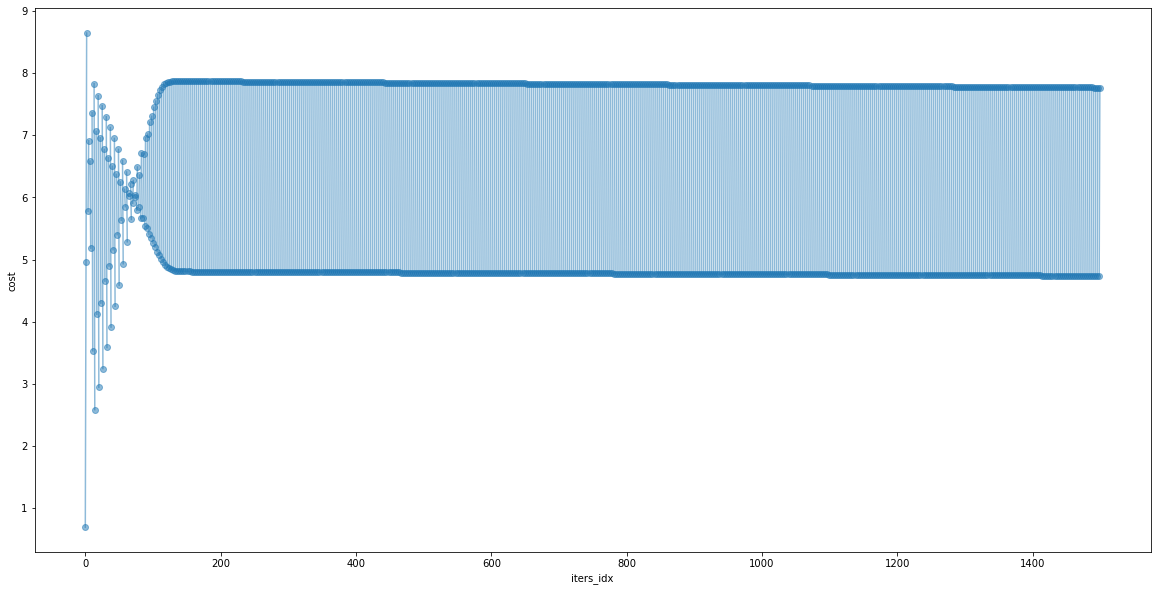

In [192]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(range(len(d1_costs)), d1_costs, '-o', color='C0', alpha=0.5)
ax.set(xlabel='iters_idx', ylabel='cost')
plt.show()

We see that the cost is not converging very quickly even after 1500 iterations, instead oscillating between two values with some drift on each of them. This indicates a narrow valley in parameter space that we are stepping too far over with each iteration, thereby not being able to get much closer to the valley minimum. In other words, the step size is too large. By reducing the step-size parameter $\alpha$ (the "_learning rate_"), we can get back on track:

In [193]:
d1_theta, d1_costs = gradient_descent(
    np.array([[0.0],[0.0],[0.0]]),
    0,
    0.001,
    1500,
    d1_X_ones,
    d1_y,
)
print(d1_theta)
print(min(d1_costs))
# [[-0.10400148]
#  [ 0.01114724]
#  [ 0.00125993]]
# 0.6225994137274377

[[-0.10400148]
 [ 0.01114724]
 [ 0.00125993]]
0.6225994137274377


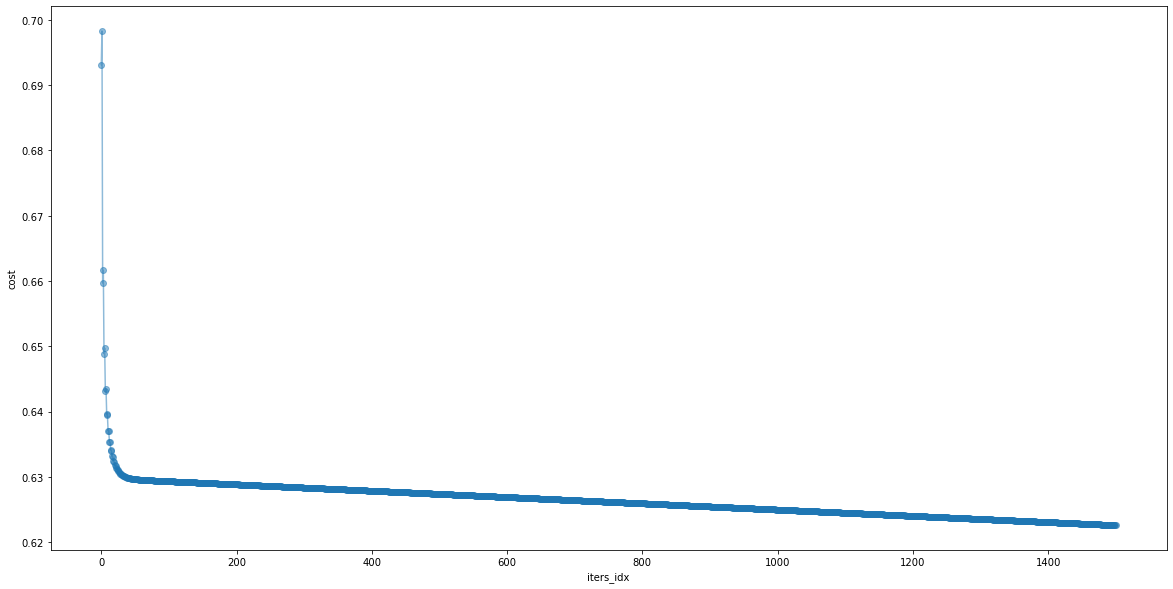

In [70]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(range(len(d1_costs)), d1_costs, '-o', color='C0', alpha=0.5)
ax.set(xlabel='iters_idx', ylabel='cost')
plt.show()

Good. Now the cost is indeed dropping further with each iteration, not oscillating as before. After a bit of experimenting, I found that about 5,000,000 iterations are needed to get close to the optimum $\overrightarrow{\theta}$ which we know is expected from the optimisation function, thanks to the notes in the given exercise code. It actually takes several minutes to run the following cell, whereas the optimisation function completes much quicker, showing how such fancier techniques go beyond simple gradient descent with constant step size:

In [194]:
d1_theta, d1_costs = gradient_descent(
    np.array([[0.0],[0.0],[0.0]]),
    0,
    0.001,
    5000000,
    d1_X_ones,
    d1_y,
)
print(d1_theta)
print(min(d1_costs))
# [[-23.12353639]
#  [  0.18993761]
#  [  0.18497899]]
# 0.20416128092026026

[[-23.12353639]
 [  0.18993761]
 [  0.18497899]]
0.20416128092026026


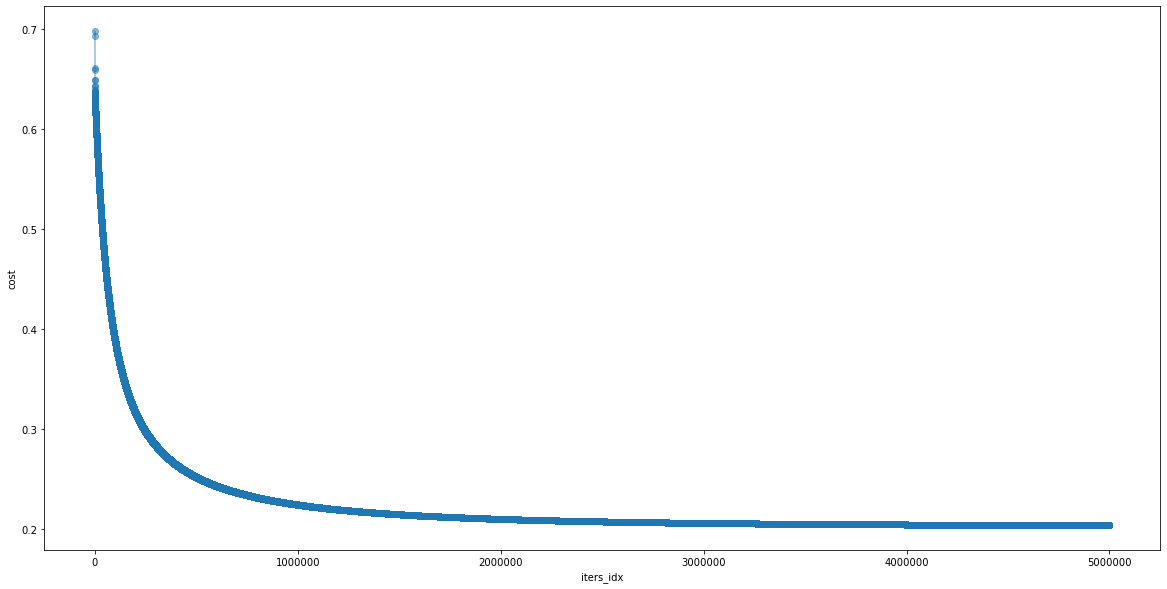

In [195]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(range(len(d1_costs)), d1_costs, '-o', color='C0', alpha=0.5)
ax.set(xlabel='iters_idx', ylabel='cost')
plt.show()

---

As mentioned above, this gradient descent method is not actually assigned as a task in the current exercise, possibly because Andrew knew that it wouldn't be very efficient. Instead, we try something different and use an automated optimiser function. In the exercise as given this is done via the Octave function ``fminunc``. Some Googling led to the following links, and hence the Python function ``fmin_bfgs`` used herein:

https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy<br>
http://aimotion.blogspot.com/2011/11/machine-learning-with-python-logistic.html<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html

When I initially made this notebook I used a combination of Pandas and Numpy. After going through all the exercises, I found that such a method was a bit cumbersome and that Pandas was unnecessary, so in a full sweep back through all exercises I rewrote everything with Numpy only. However, even though the following running of ``fmin_bfgs`` was fine with the Pandas-Numpy combination, some numerical issue crops up with Numpy only, possibly related to step size or something like that. Later use of the optimisation function doesn't have this issue, so it doesn't seem like a problem with imlementation. I chose to ignore for now as we know the desired optimum $\overrightarrow{\theta}$ anyway and can progress with that, plus the above gradient descent method gives a fairly decent answer too:

In [196]:
d1_theta = get_theta(
    np.array([[0.0],[0.0],[0.0]]),
    0,
    400,
    d1_X_ones,
    d1_y,
)
print(d1_theta)

         Current function value: nan
         Iterations: 1
         Function evaluations: 560
         Gradient evaluations: 112
[[  6.28160425]
 [754.37095603]
 [707.48666401]]


/Users/Kyo/miniconda3/envs/py3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/Kyo/miniconda3/envs/py3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
/Users/Kyo/miniconda3/envs/py3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/Kyo/miniconda3/envs/py3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
/Users/Kyo/miniconda3/envs/py3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/Kyo/miniconda3/envs/py3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


In [197]:
# d1_theta = np.array([[-25.16120641],[0.20623071],[0.20147054]]) # From first attempt at this exercise with Pandas-Numpy combination
d1_theta = np.array([[-23.12353639],[0.18993761],[0.18497899]]) # From gradient descent

The "current function value" from ``fmin_bfgs`` is the final cost value. Note that this opimiser function is relevant for situations where the parameters $\overrightarrow{\theta}$ are unconstrained i.e. can take any value.

Now let's plot the data. Note that the equation for a plane is:

$\overrightarrow{r} \cdot \overrightarrow{n} = c$

Where:

$\overrightarrow{r}$ is a vector from the origin to the plane<br>
$\overrightarrow{n}$ is the normal vector of the plane<br>
$c$ is a constant scalar value

If we multiply out this equation and rearrange for $r_z$, we get:

$[r_x, r_y, r_z] \cdot [n_x, n_y, n_z] = c$<br>
$r_xn_x + r_yn_y + r_zn_z = c$<br>
$r_xn_x/n_z + r_yn_y/n_z + r_z = c/n_z$<br>
$r_z = c/n_z - r_xn_x/n_z - r_yn_y/n_z$<br>
$r_z = [1, r_x, r_y] \cdot [c/n_z, -n_x/n_z, -n_y/n_z]$

In this work, we calculate a vector $\overrightarrow{\theta}$ that describes the parameters of the plane that results in $r_z$ when given a vector $[1, r_x, r_y]$. We can see from the above that this theta vector is therefore:

$[\theta_0, \theta_1, \theta_2] = [c/n_z, -n_x/n_z, -n_y/n_z]$

And so:

$r_z = [1, r_x, r_y] \cdot [\theta_0, \theta_1, \theta_2]$

For a given set of $r_x$ and $r_y$, we can calculate the $r_z$ through this equation. Furthermore, by setting $r_z$ to a specific value, we can calculate the $r_y$, say, for a given set of $r_x$. So if we want to find the $r_y$ for where the plane has $z=0$, we have:

$0 = [1, r_x, r_y] \cdot [\theta_0, \theta_1, \theta_2]$<br>
$0 = \theta_0 + r_x\theta_1 + r_y\theta_2$<br>
$r_y = - (\theta_0 + r_x\theta_1) / \theta_2$

This is good to know, but actually below I just give the full boundary surface to the contour function and let it do its thing at $r_z=0$.

In [216]:
d1_X1_range = max(d1_X[:,0]) - min(d1_X[:,0])
d1_Xfit1_lower = min(d1_X[:,0]) - (d1_X1_range * 0.0)
d1_Xfit1_upper = max(d1_X[:,0]) + (d1_X1_range * 0.0)

d1_X2_range = max(d1_X[:,1]) - min(d1_X[:,1])
d1_Xfit2_lower = min(d1_X[:,1]) - (d1_X2_range * 0.0)
d1_Xfit2_upper = max(d1_X[:,1]) + (d1_X2_range * 0.0)

d1_Xfit1 = np.linspace(d1_Xfit1_lower, d1_Xfit1_upper, 100)
d1_Xfit2 = np.linspace(d1_Xfit2_lower, d1_Xfit2_upper, 100)

# Note that the meshgrids, and everything that follows from them, are in [x2,x1] order, not [x1,x2]. Dunno why that is, counterintuitive.

d1_Xfit1_meshgrid, d1_Xfit2_meshgrid = np.meshgrid(d1_Xfit1, d1_Xfit2)

d1_Xfit = np.transpose([d1_Xfit1_meshgrid.flatten(), d1_Xfit2_meshgrid.flatten()])
d1_Xfit_ones = add_ones(d1_Xfit)

d1_hfit = np.dot(d1_Xfit_ones, d1_theta)
d1_hfit_meshgrid = np.reshape(d1_hfit, [d1_Xfit2.shape[0], d1_Xfit1.shape[0]])

# d1_Xfit2_at_z0 = - (d1_theta[0] + d1_Xfit1 * d1_theta[1]) / d1_theta[2]

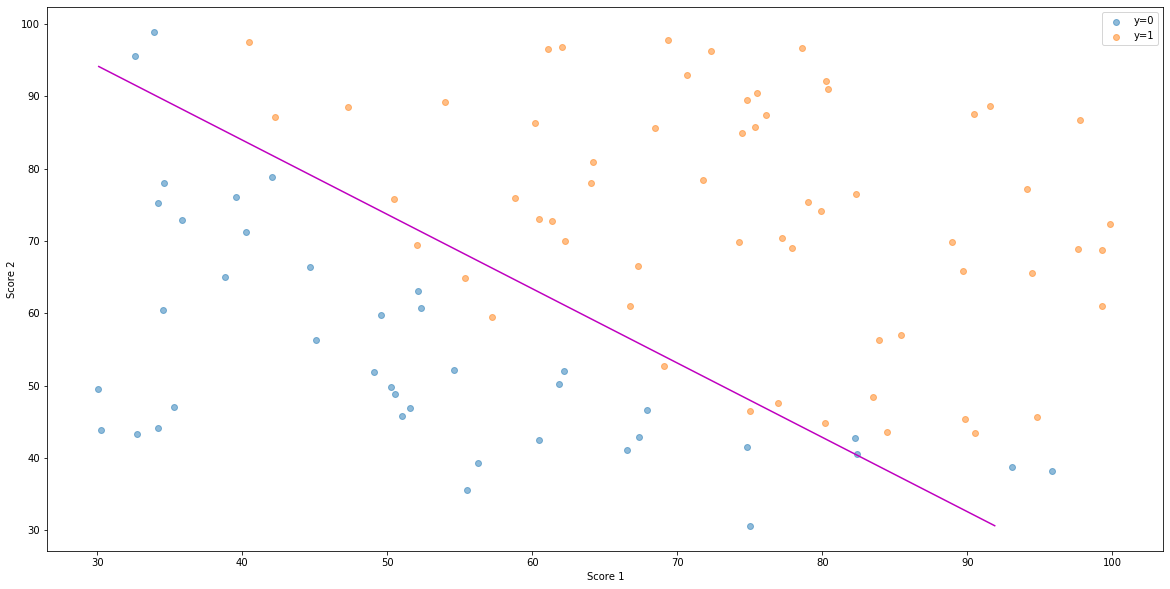

In [217]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d1_X[d1_y_idx0,0], d1_X[d1_y_idx0,1], color='C0', alpha=0.5)
ax.scatter(d1_X[d1_y_idx1,0], d1_X[d1_y_idx1,1], color='C1', alpha=0.5)
# ax.plot(d1_Xfit1, d1_Xfit2_at_z0, '-', color='m')
ax.contour(d1_Xfit1_meshgrid, d1_Xfit2_meshgrid, d1_hfit_meshgrid, [0], colors=['m'])
ax.set(xlabel='Score 1', ylabel='Score 2')
ax.legend(['y=0', 'y=1']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

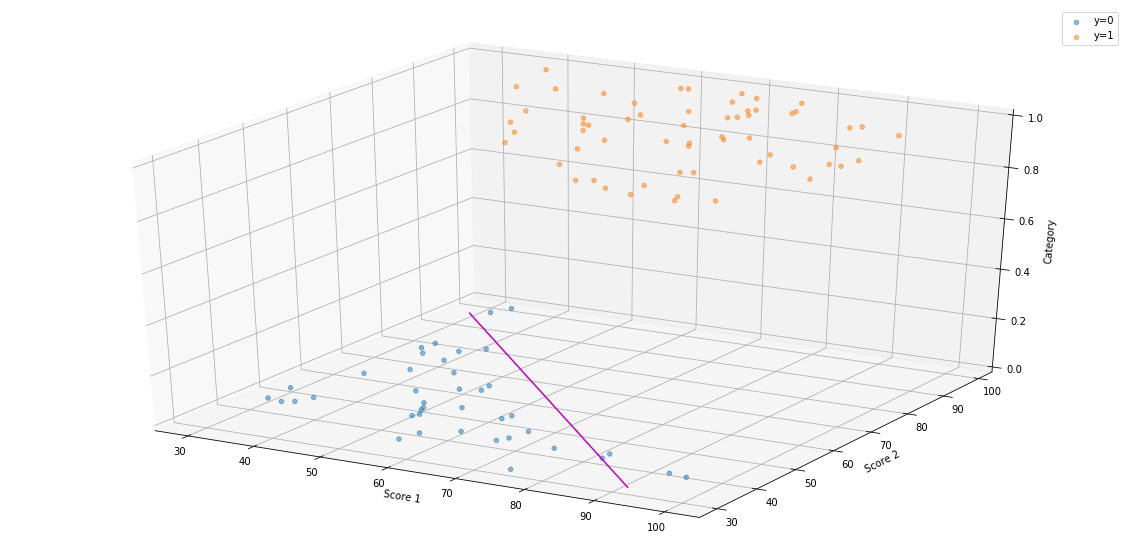

In [200]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.scatter(d1_X[d1_y_idx0,0], d1_X[d1_y_idx0,1], [0]*len(d1_y_idx0), color='C0', alpha=0.5)
ax.scatter(d1_X[d1_y_idx1,0], d1_X[d1_y_idx1,1], [1]*len(d1_y_idx1), color='C1', alpha=0.5)
# ax.plot(d1_Xfit1, d1_Xfit2_at_z0, '-', color='m')
ax.contour(d1_Xfit1_meshgrid, d1_Xfit2_meshgrid, d1_hfit_meshgrid, [0], colors=['m'])
ax.set_zlim([0,1])
ax.set(xlabel='Score 1', ylabel='Score 2', zlabel='Category')
ax.legend(['y=0', 'y=1']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

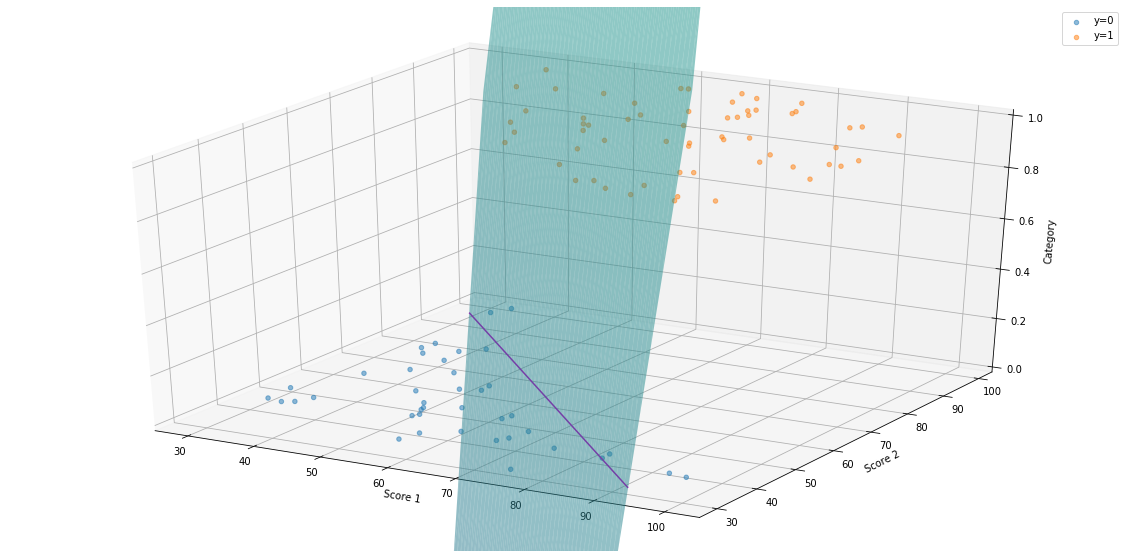

In [167]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.scatter(d1_X[d1_y_idx0,0], d1_X[d1_y_idx0,1], [0]*len(d1_y_idx0), color='C0', alpha=0.5)
ax.scatter(d1_X[d1_y_idx1,0], d1_X[d1_y_idx1,1], [1]*len(d1_y_idx1), color='C1', alpha=0.5)
# ax.plot(d1_Xfit1, d1_Xfit2_at_z0, '-', color='m')
ax.contour(d1_Xfit1_meshgrid, d1_Xfit2_meshgrid, d1_hfit_meshgrid, [0], colors=['m'])
ax.plot_surface(d1_Xfit1_meshgrid, d1_Xfit2_meshgrid, d1_hfit_meshgrid, cmap=cm.viridis, alpha=0.5)
ax.set_zlim([0,1])
ax.set(xlabel='Score 1', ylabel='Score 2', zlabel='Category')
ax.legend(['y=0', 'y=1']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

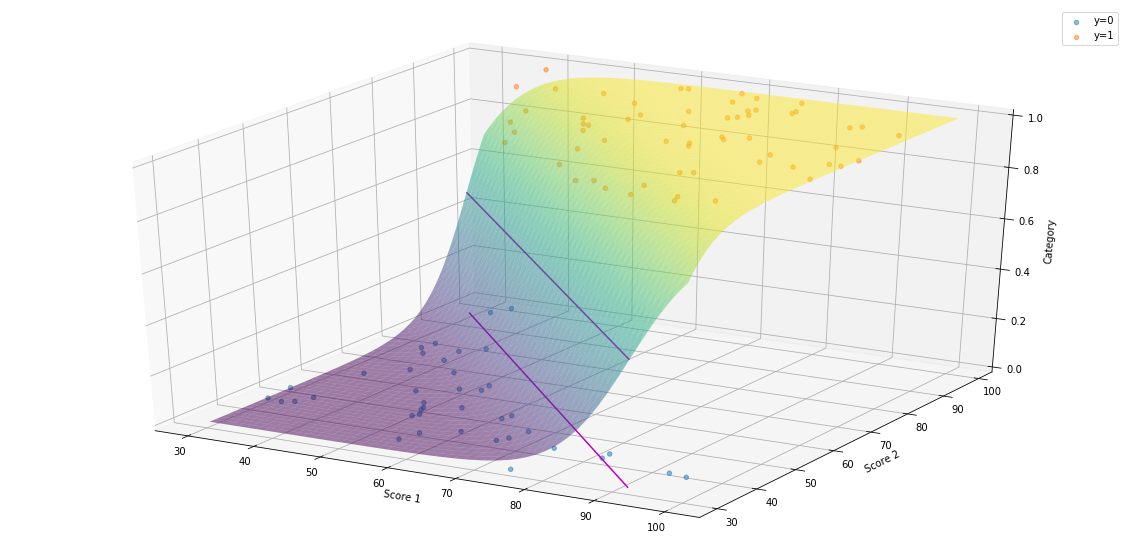

In [171]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.scatter(d1_X[d1_y_idx0,0], d1_X[d1_y_idx0,1], [0]*len(d1_y_idx0), color='C0', alpha=0.5)
ax.scatter(d1_X[d1_y_idx1,0], d1_X[d1_y_idx1,1], [1]*len(d1_y_idx1), color='C1', alpha=0.5)
# ax.plot(d1_Xfit1, d1_Xfit2_at_z0, '-', color='m')
ax.contour(d1_Xfit1_meshgrid, d1_Xfit2_meshgrid, d1_hfit_meshgrid, [0], colors=['m'])
ax.contour(d1_Xfit1_meshgrid, d1_Xfit2_meshgrid, sigmoid(d1_hfit_meshgrid), [0.5], colors=['m'])
ax.plot_surface(d1_Xfit1_meshgrid, d1_Xfit2_meshgrid, sigmoid(d1_hfit_meshgrid), cmap=cm.viridis, alpha=0.5)
ax.set_zlim([0,1])
ax.set(xlabel='Score 1', ylabel='Score 2', zlabel='Category')
ax.legend(['y=0', 'y=1']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

---

Remember that the boundary surface that we found is not a data prediction surface, as we did not optimise the fit for it to match the data. The important things about it are:

1) where it cuts the $z=0$ plane, thereby defining the mid-point of the sigmoid function<br>
2) in which direction it tilts, thereby defining which of the two regions defined by the $z=0$ line maps to the lower half of the sigmoid function and which to the upper half

The data prediction is given by the rounded sigmoid of the boundary surface value. The value must be rounded as the sigmoid gives a floating value between 0 and 1, but we simply want a category label of exactly 0 or 1. So, for a set of scores:

$[score_1, score_2] = [45, 85]$

we have a sigmoid of:

In [202]:
sigmoid(np.dot(np.array([1.0, 45.0, 85.0]), d1_theta))

array([0.75893878])

and so a predicted category label of:

In [203]:
np.round(sigmoid(np.dot(np.array([1.0, 45.0, 85.0]), d1_theta)))

array([1.])

---

Let's compare all predictions for the given data set itself, and compare with the known labels to get an overall accuracy score:

In [213]:
d1_predictions = np.round(sigmoid(np.dot(d1_X_ones, d1_theta)))
d1_accuracy = np.mean(d1_y == d1_predictions)
d1_accuracy
# 0.89

0.89

# Exercise 2.2: Logistic Regression (dimension-2, power-6, category-2, regularised)
---

Now on to some other data:

In [88]:
d2 = np.loadtxt('ex2/ex2data2.txt', delimiter=',')
d2.shape

(118, 3)

In [89]:
d2_X = d2[:,0:2]
d2_X.shape

(118, 2)

In [91]:
d2_y = np.transpose([d2[:,2]])
d2_y.shape

(118, 1)

In [221]:
del(d2)

In [92]:
d2_y_idx0 = np.where(d2_y == 0)[0]
d2_y_idx1 = np.where(d2_y == 1)[0]

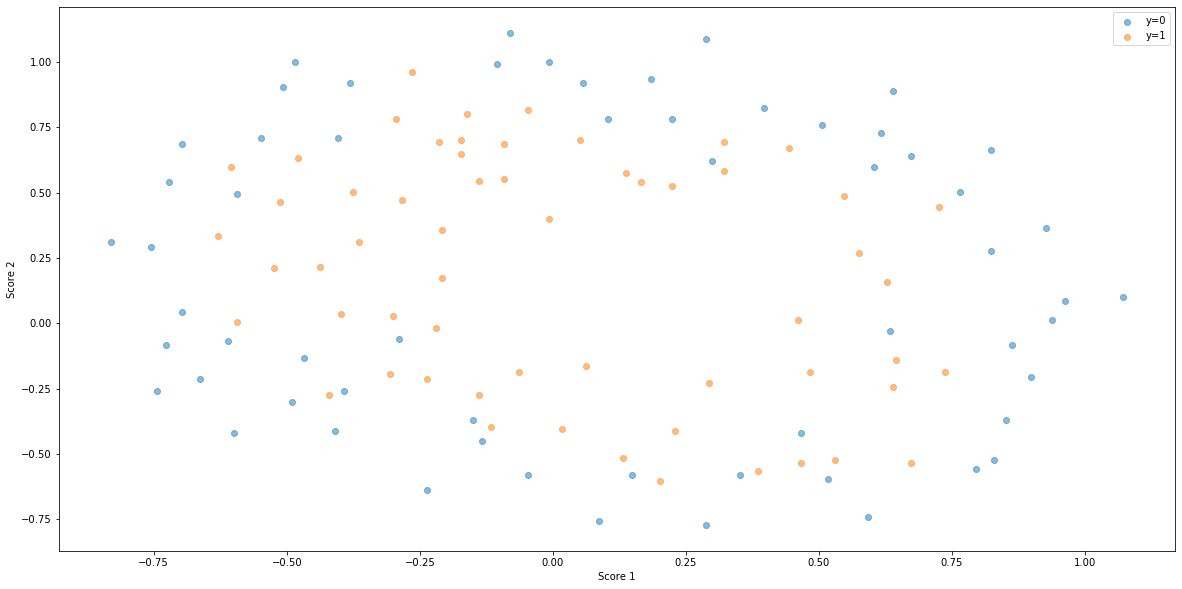

In [93]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d2_X[d2_y_idx0,0], d2_X[d2_y_idx0,1], color='C0', alpha=0.5)
ax.scatter(d2_X[d2_y_idx1,0], d2_X[d2_y_idx1,1], color='C1', alpha=0.5)
ax.set(xlabel='Score 1', ylabel='Score 2')
ax.legend(['y=0', 'y=1'])
plt.show()

---

This data set has two categories that are not separable by a flat boundary surface that cuts $z=0$. Instead, we want some kind of curved boundary surface that cuts $z=0$ in a loop. When we were fitting a plane earlier on, we had the $\overrightarrow{r} \cdot \overrightarrow{n} = c$ formula that led to:

$r_z = [1, r_x, r_y] \cdot [\theta_0, \theta_1, \theta_2]$

If we add more terms in higher powers of the input data to the first vector of the dot product, with counterpart $\overrightarrow{\theta}$ components, then we can describe just such a curved surface as required for this problem. In exercise-5.3 we add a simple series of higher powers to create a 1D polynomial hypothesis function, but here we use a more complicated set of combinations of the 2D features already in hand. After adding the new features, we then add the ones as usual:

In [205]:
def add_features(
    X,
    degrees_num,
):

    X_features = X
    X1 = np.transpose([X[:,0]])
    X2 = np.transpose([X[:,1]])

    for i in range(0, degrees_num+1):
        for j in range(0, i+1):
            X_features = np.append(X_features, np.power(X1, i-j) * np.power(X2, j), axis=1)

    return(X_features)

# i j
# 0 0 x1^0 * x2^0
# 1 0 x1^1 * x2^0
# 1 1 x1^0 * x2^1
# 2 0 x1^2 * x2^0
# 2 1 x1^1 * x2^1
# 2 2 x1^0 * x2^2
# .
# .
# .

In [206]:
d2_X_features = add_features(d2_X, 6)
d2_X_features.shape

(118, 30)

In [207]:
d2_X_features_ones = add_ones(d2_X_features)
d2_X_features_ones.shape

(118, 31)

---

Check the cost function with this data set with different regularisation parameter settings:

In [208]:
d2_cost, d2_dcost_by_dtheta = get_cost(
    np.array([[0.0]] * d2_X_features_ones.shape[1]),
    1,
    d2_X_features_ones,
    d2_y,
)
print(d2_cost)
print(d2_dcost_by_dtheta)
# 0.6931471805599454
# [[8.47457627e-03]
#  [1.87880932e-02]
#  [7.77711864e-05]
#  [8.47457627e-03]
#  [1.87880932e-02]
#  ...

# From original Pandas-Numpy implementation:
# 0.693
# x1^0 * x2^0    0.008475
# x1^1 * x2^0    0.018788
# x1^0 * x2^1    0.000078
# x1^2 * x2^0    0.050345
# x1^1 * x2^1    0.011501

0.6931471805599454
[[8.47457627e-03]
 [1.87880932e-02]
 [7.77711864e-05]
 [8.47457627e-03]
 [1.87880932e-02]
 [7.77711864e-05]
 [5.03446395e-02]
 [1.15013308e-02]
 [3.76648474e-02]
 [1.83559872e-02]
 [7.32393391e-03]
 [8.19244468e-03]
 [2.34764889e-02]
 [3.93486234e-02]
 [2.23923907e-03]
 [1.28600503e-02]
 [3.09593720e-03]
 [3.93028171e-02]
 [1.99707467e-02]
 [4.32983232e-03]
 [3.38643902e-03]
 [5.83822078e-03]
 [4.47629067e-03]
 [3.10079849e-02]
 [3.10312442e-02]
 [1.09740238e-03]
 [6.31570797e-03]
 [4.08503006e-04]
 [7.26504316e-03]
 [1.37646175e-03]
 [3.87936363e-02]]


In [209]:
d2_cost, d2_dcost_by_dtheta = get_cost(
    np.array([[1.0]] * d2_X_features_ones.shape[1]),
    10,
    d2_X_features_ones,
    d2_y,
)
print(d2_cost)
print(d2_dcost_by_dtheta)
# 3.858054705640334
# [[0.41030551]
#  [0.15643422]
#  [0.19454505]
#  [0.49505127]
#  [0.15643422]
#  ...

# From original Pandas-Numpy implementation:
# 3.165
# x1^0 * x2^0    0.346045
# x1^1 * x2^0    0.161352
# x1^0 * x2^1    0.194796
# x1^2 * x2^0    0.226863
# x1^1 * x2^1    0.092186

3.858054705640334
[[0.41030551]
 [0.15643422]
 [0.19454505]
 [0.49505127]
 [0.15643422]
 [0.19454505]
 [0.2386283 ]
 [0.0855726 ]
 [0.25724404]
 [0.14218266]
 [0.10881443]
 [0.10197493]
 [0.1841413 ]
 [0.17770904]
 [0.08514304]
 [0.12040938]
 [0.08366463]
 [0.2045241 ]
 [0.13479316]
 [0.09515703]
 [0.09343396]
 [0.0999505 ]
 [0.09127138]
 [0.17537525]
 [0.15144963]
 [0.08589394]
 [0.09971592]
 [0.08468776]
 [0.10265106]
 [0.08360533]
 [0.18430921]]


---

Run the optimisation function to find the optimum $\overrightarrow{\theta}$ for a regularised polynomial fit:

In [210]:
d2_theta = get_theta(
    np.array([[0.0]] * d2_X_features_ones.shape[1]),
    1,
    400,
    d2_X_features_ones,
    d2_y,
)
print(d2_theta)
# Optimization terminated successfully.
#          Current function value: 0.524530
#          Iterations: 53
#          Function evaluations: 1782
#          Gradient evaluations: 54
# [[ 1.28980196e+00]
#  [ 3.76670337e-01]
#  [ 6.94413381e-01]
#  [ 5.05899111e-06]
#  [ 3.76670391e-01]
#  ...

# From original Pandas-Numpy implementation:
# Optimization terminated successfully.
#          Current function value: 0.529003
#          Iterations: 47
#          Function evaluations: 1440
#          Gradient evaluations: 48
# array([ 1.2726874 ,  0.6255702 ,  1.18096656, -2.01919809, -0.91761473,
#        -1.43194191,  0.12375929, -0.36513113, -0.35703421, -0.174858  ,
#        -1.45843793, -0.05129707, -0.61603957, -0.27464152, -1.19282596,
#        -0.24270345, -0.20570072, -0.04499829, -0.27782723, -0.29525889,
#        -0.4561329 , -1.04377877,  0.02762802, -0.29265683,  0.01543356,
#        -0.32759349, -0.14389184, -0.92460135])

Optimization terminated successfully.
         Current function value: 0.524530
         Iterations: 53
         Function evaluations: 1782
         Gradient evaluations: 54
[[ 1.28980196e+00]
 [ 3.76670337e-01]
 [ 6.94413381e-01]
 [ 5.05899111e-06]
 [ 3.76670391e-01]
 [ 6.94413361e-01]
 [-2.04322220e+00]
 [-9.54089468e-01]
 [-1.48651509e+00]
 [ 3.80475523e-02]
 [-4.37535667e-01]
 [-3.88588582e-01]
 [-3.25297955e-01]
 [-1.47077104e+00]
 [-6.33110722e-02]
 [-6.28693434e-01]
 [-2.99906386e-01]
 [-1.21056936e+00]
 [-2.77922827e-01]
 [-2.29999143e-01]
 [-5.33670327e-02]
 [-2.96931314e-01]
 [-3.08214916e-01]
 [-5.02657216e-01]
 [-1.04939424e+00]
 [ 2.20741899e-02]
 [-2.97235582e-01]
 [ 9.43678142e-03]
 [-3.31476088e-01]
 [-1.58528096e-01]
 [-9.18857762e-01]]


Let's see the fit according to the parameters found:

In [218]:
d2_X1_range = max(d2_X[:,0]) - min(d2_X[:,0])
d2_Xfit1_lower = min(d2_X[:,0]) - (d2_X1_range * 0.0)
d2_Xfit1_upper = max(d2_X[:,0]) + (d2_X1_range * 0.0)

d2_X2_range = max(d2_X[:,1]) - min(d2_X[:,1])
d2_Xfit2_lower = min(d2_X[:,1]) - (d2_X2_range * 0.0)
d2_Xfit2_upper = max(d2_X[:,1]) + (d2_X2_range * 0.0)

d2_Xfit1 = np.linspace(d2_Xfit1_lower, d2_Xfit1_upper, 100)
d2_Xfit2 = np.linspace(d2_Xfit2_lower, d2_Xfit2_upper, 100)

# Note that the meshgrids, and everything that follows from them, are in [x2,x1] order, not [x1,x2]. Dunno why that is, counterintuitive.

d2_Xfit1_meshgrid, d2_Xfit2_meshgrid = np.meshgrid(d2_Xfit1, d2_Xfit2)

d2_Xfit = np.transpose([d2_Xfit1_meshgrid.flatten(), d2_Xfit2_meshgrid.flatten()])
d2_Xfit_features = add_features(d2_Xfit, 6)
d2_Xfit_features_ones = add_ones(d2_Xfit_features)

d2_hfit = np.dot(d2_Xfit_features_ones, d2_theta)
d2_hfit_meshgrid = np.reshape(d2_hfit, [d2_Xfit2.shape[0], d2_Xfit1.shape[0]])

# d2_Xfit2_at_z0 = - (d2_theta[0] + d2_Xfit1 * d2_theta[1]) / d2_theta[2]

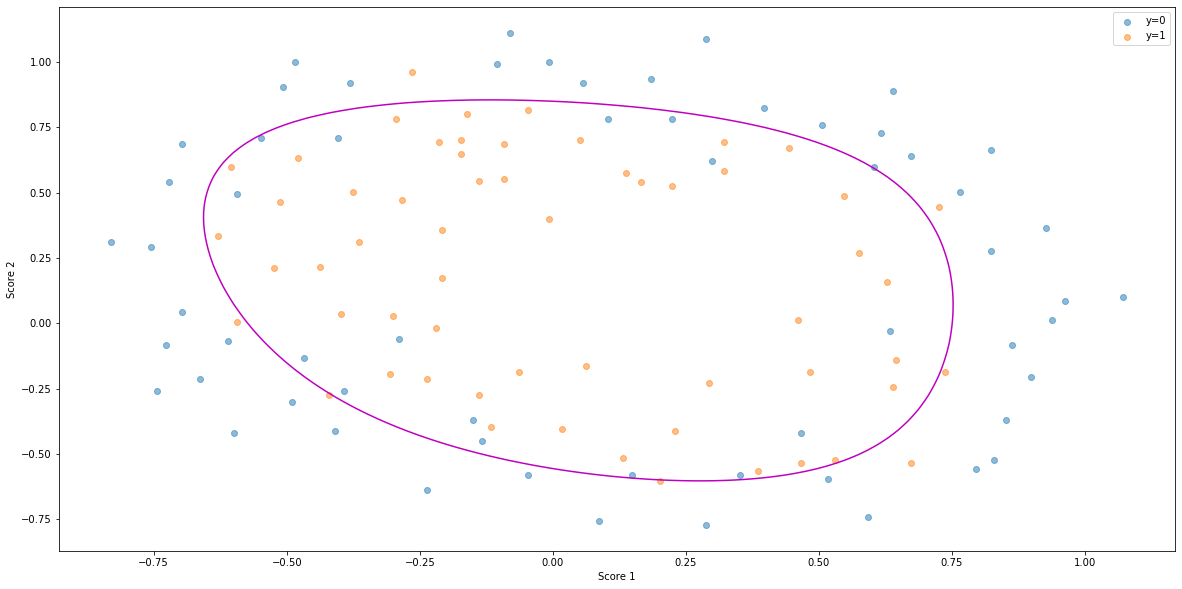

In [219]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d2_X[d2_y_idx0,0], d2_X[d2_y_idx0,1], color='C0', alpha=0.5)
ax.scatter(d2_X[d2_y_idx1,0], d2_X[d2_y_idx1,1], color='C1', alpha=0.5)
# ax.plot(d2_Xfit1, d2_Xfit2_at_z0, '-', color='m')
ax.contour(d2_Xfit1_meshgrid, d2_Xfit2_meshgrid, d2_hfit_meshgrid, [0], colors=['m'])
ax.set(xlabel='Score 1', ylabel='Score 2')
ax.legend(['y=0', 'y=1']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

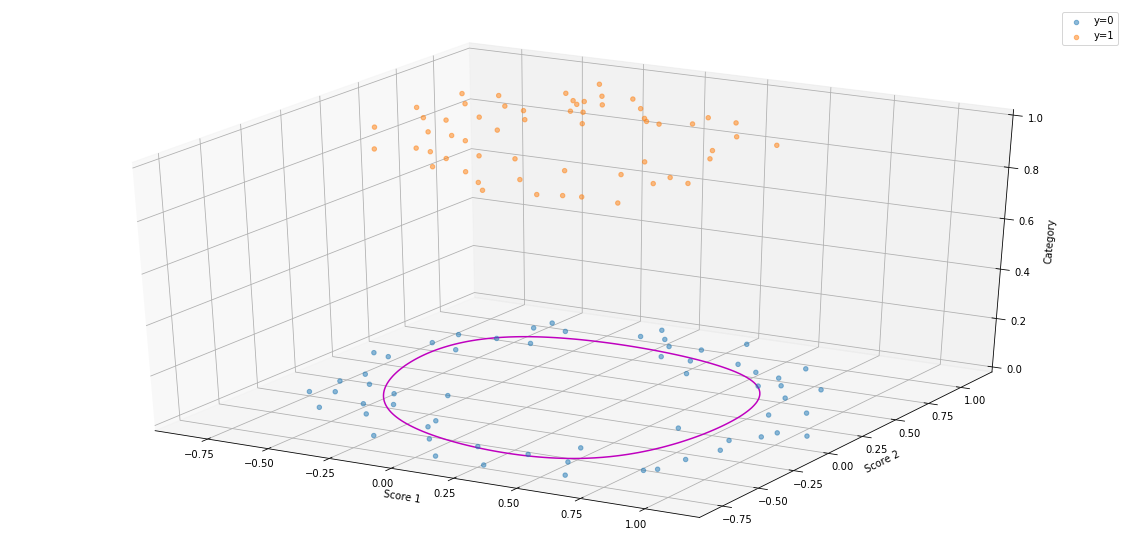

In [177]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.scatter(d2_X[d2_y_idx0,0], d2_X[d2_y_idx0,1], [0]*len(d2_y_idx0), color='C0', alpha=0.5)
ax.scatter(d2_X[d2_y_idx1,0], d2_X[d2_y_idx1,1], [1]*len(d2_y_idx1), color='C1', alpha=0.5)
# ax.plot(d2_Xfit1, d2_Xfit2_at_z0, '-', color='m')
ax.contour(d2_Xfit1_meshgrid, d2_Xfit2_meshgrid, d2_hfit_meshgrid, [0], colors=['m'])
ax.set_zlim([0,1])
ax.set(xlabel='Score 1', ylabel='Score 2', zlabel='Category')
ax.legend(['y=0', 'y=1']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

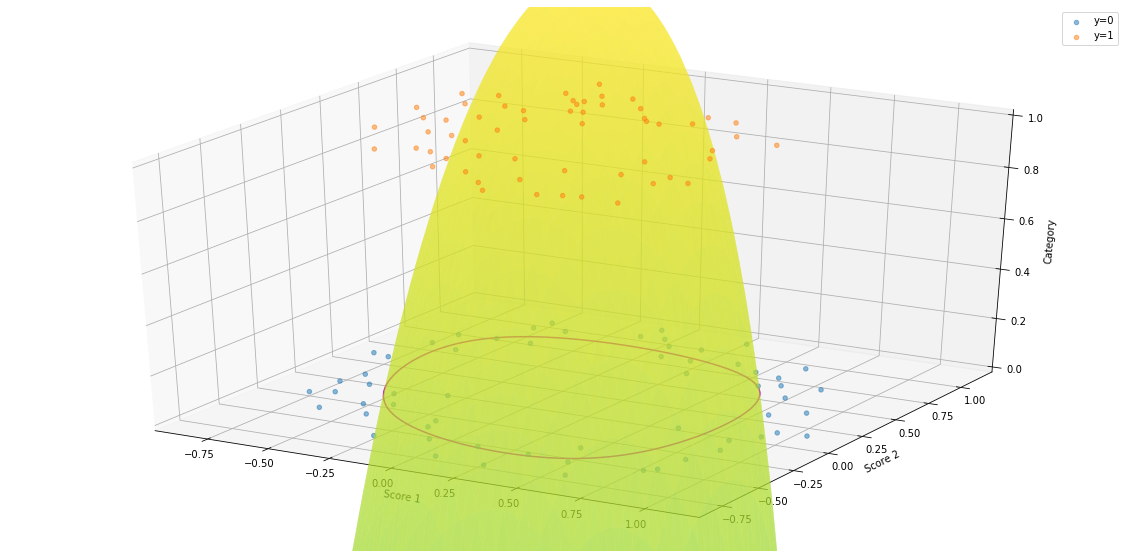

In [178]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.scatter(d2_X[d2_y_idx0,0], d2_X[d2_y_idx0,1], [0]*len(d2_y_idx0), color='C0', alpha=0.5)
ax.scatter(d2_X[d2_y_idx1,0], d2_X[d2_y_idx1,1], [1]*len(d2_y_idx1), color='C1', alpha=0.5)
# ax.plot(d2_Xfit1, d2_Xfit2_at_z0, '-', color='m')
ax.contour(d2_Xfit1_meshgrid, d2_Xfit2_meshgrid, d2_hfit_meshgrid, [0], colors=['m'])
ax.plot_surface(d2_Xfit1_meshgrid, d2_Xfit2_meshgrid, d2_hfit_meshgrid, cmap=cm.viridis, alpha=0.5)
ax.set_zlim([0,1])
ax.set(xlabel='Score 1', ylabel='Score 2', zlabel='Category')
ax.legend(['y=0', 'y=1']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

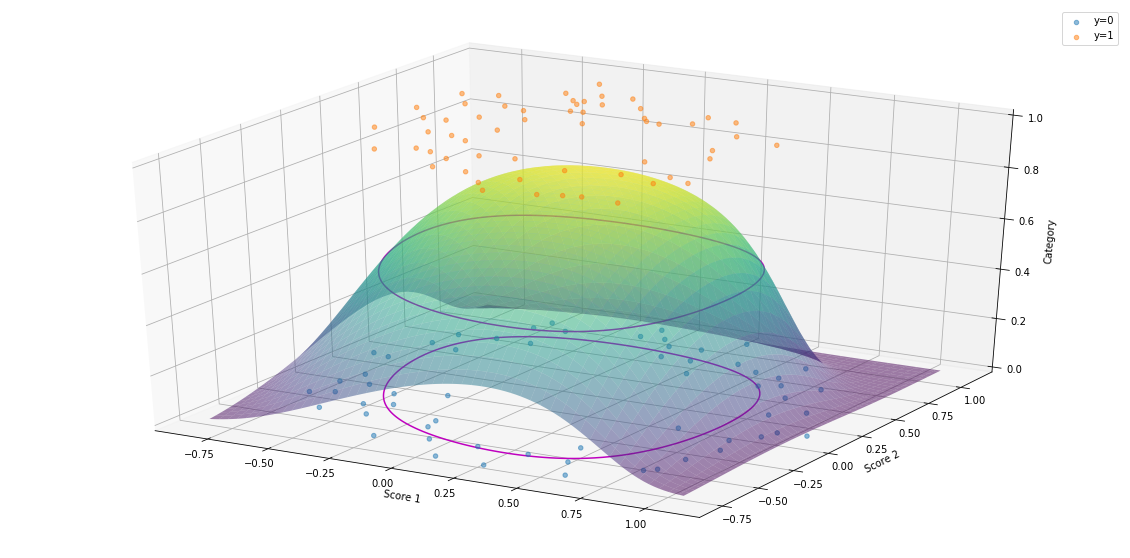

In [179]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.scatter(d2_X[d2_y_idx0,0], d2_X[d2_y_idx0,1], [0]*len(d2_y_idx0), color='C0', alpha=0.5)
ax.scatter(d2_X[d2_y_idx1,0], d2_X[d2_y_idx1,1], [1]*len(d2_y_idx1), color='C1', alpha=0.5)
# ax.plot(d2_Xfit1, d2_Xfit2_at_z0, '-', color='m')
ax.contour(d2_Xfit1_meshgrid, d2_Xfit2_meshgrid, d2_hfit_meshgrid, [0], colors=['m'])
ax.contour(d2_Xfit1_meshgrid, d2_Xfit2_meshgrid, sigmoid(d2_hfit_meshgrid), [0.5], colors=['m'])
ax.plot_surface(d2_Xfit1_meshgrid, d2_Xfit2_meshgrid, sigmoid(d2_hfit_meshgrid), cmap=cm.viridis, alpha=0.5)
ax.set_zlim([0,1])
ax.set(xlabel='Score 1', ylabel='Score 2', zlabel='Category')
ax.legend(['y=0', 'y=1']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

---

Let's compare all predictions for the given data set itself, and compare with the known labels to get an overall accuracy score:

In [212]:
d2_predictions = np.round(sigmoid(np.dot(d2_X_features_ones, d2_theta)))
d2_accuracy = np.mean(d2_y == d2_predictions)
d2_accuracy
# 0.8135593220338984

0.8135593220338984